# Qulacs & openfermion VQE Methane


- qulacs
- openfermion
- openfermion-psi4
- psi4
- scipy
- numpy

In [5]:
import sys, os
import qulacs

from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.utils import Grid
from openfermion.linalg import get_sparse_operator
from openfermion.chem import MolecularData
from openfermionpsi4 import run_psi4

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from openfermion.chem import geometry_from_pubchem

methane_geometry = geometry_from_pubchem('methane')
print(methane_geometry)


[('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), ('H', (-0.4593, 0.3874, -0.9121))]


In [7]:
from openfermion.chem import MolecularData

# Set parameters to make a simple molecule.
diatomic_bond_length = 1.10
geometry = [('C', (0, 0, 0)), ('H', (0.5541, 0.7996, 0.4965)), ('H', (0.6833, -0.8134, -0.2536)), ('H', (-0.7782, -0.3735, 0.6692)), ('H', (-0.4593, 0.3874, -0.9121))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = str(diatomic_bond_length)

# Make molecule and print out a few interesting facts about it.
molecule = MolecularData(geometry, basis, multiplicity,
                         charge, description)
print('Molecule has automatically generated name {}'.format(
    molecule.name))
print('Information about this molecule would be saved at:\n{}\n'.format(
    molecule.filename))
print('This molecule has {} atoms and {} electrons.'.format(
    molecule.n_atoms, molecule.n_electrons))
for atom, atomic_number in zip(molecule.atoms, molecule.protons):
    print('Contains {} atom, which has {} protons.'.format(
        atom, atomic_number))

Molecule has automatically generated name H4-C1_sto-3g_singlet_1.1
Information about this molecule would be saved at:
/home/yourn/.conda/envs/qe/lib/python3.9/site-packages/openfermion/testing/data/H4-C1_sto-3g_singlet_1.1

This molecule has 5 atoms and 10 electrons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.
Contains C atom, which has 6 protons.



At bond length of 0.2 angstrom, molecular water has:
Hartree-Fock energy of -1.0913860712239405 Hartree.
MP2 energy of -1.1115346455262156 Hartree.
FCI energy of -1.1232535039083005 Hartree.
Nuclear repulsion energy between protons is 0.5291772106700001 Hartree.
Spatial orbital 0 has energy of -0.5229341228278748 Hartree.
Spatial orbital 1 has energy of 0.18809294510395247 Hartree.
Spatial orbital 2 has energy of 1.0676311462776364 Hartree.
Spatial orbital 3 has energy of 1.2987032391834068 Hartree.

At bond length of 0.4 angstrom, molecular water has:
Hartree-Fock energy of -1.0913860712239405 Hartree.
MP2 energy of -1.1115346455262156 Hartree.
FCI energy of -1.1232535039083005 Hartree.
Nuclear repulsion energy between protons is 0.5291772106700001 Hartree.
Spatial orbital 0 has energy of -0.5229341228278748 Hartree.
Spatial orbital 1 has energy of 0.18809294510395247 Hartree.
Spatial orbital 2 has energy of 1.0676311462776364 Hartree.
Spatial orbital 3 has energy of 1.29870323918340

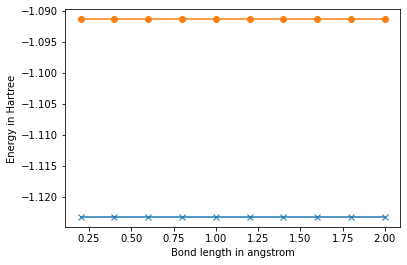

In [8]:
from openfermion.chem import MolecularData
from openfermionpsi4 import run_psi4

# Set molecule parameters.
basis = '3-21g'
multiplicity = 1
bond_length_interval = 0.2
n_points = 10

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(1, n_points + 1):
    bond_length = bond_length_interval * float(point)
    bond_lengths += [bond_length]
    geometry = [('H', (2, 0, 0)), ('H', (3, 0, 0))]
    molecule = MolecularData(
        geometry, basis, multiplicity,
        description=str(round(bond_length, 2)))
    
    # Run Psi4.
    molecule = run_psi4(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)
    n_qubit = molecule.n_qubits
    n_electron = molecule.n_electrons

    # Print out some results of calculation.
    print('\nAt bond length of {} angstrom, molecular water has:'.format(
        bond_length))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
        molecule.nuclear_repulsion))
    for orbital in range(molecule.n_orbitals):
        print('Spatial orbital {} has energy of {} Hartree.'.format(
            orbital, molecule.orbital_energies[orbital]))
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

"Interestingly, their calculations suggested that the TiO2
molecule is linear in the excited states." [1]

[1] [Wu, H. and Wang, L., 1997. Electronic structure of titanium oxide clusters: TiOy (y = 1−3) and (TiO2)n (n = 1−4). The Journal of Chemical Physics, 107(20), pp.8221-8228(8225).]

In [9]:
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

In [10]:
print(jw_hamiltonian)

(2.4221246156286966+0j) [] +
(-0.028650035649416403+0j) [X0 X1 Y2 Y3] +
(-0.019854733713720266+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.019854733713720266+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.02383659085063969+0j) [X0 X1 Y4 Y5] +
(-0.026580713372430325+0j) [X0 X1 Y6 Y7] +
(0.028650035649416403+0j) [X0 Y1 Y2 X3] +
(0.019854733713720266+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.019854733713720266+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.02383659085063969+0j) [X0 Y1 Y4 X5] +
(0.026580713372430325+0j) [X0 Y1 Y6 X7] +
(0.003595403695266113+0j) [X0 Z1 X2 X3 Z4 X5] +
(0.003595403695266113+0j) [X0 Z1 X2 Y3 Z4 Y5] +
(0.01908335003252647+0j) [X0 Z1 X2 X4 Z5 X6] +
(0.01160142117481791+0j) [X0 Z1 X2 Y4 Z5 Y6] +
(0.03218519964639925+0j) [X0 Z1 X2 X5 Z6 X7] +
(0.03218519964639925+0j) [X0 Z1 X2 Y5 Z6 Y7] +
(0.007481928857708556+0j) [X0 Z1 Y2 Y4 Z5 X6] +
(-0.020583778471581323+0j) [X0 Z1 Z2 X3 Y4 Z5 Z6 Y7] +
(-0.013101849613872773+0j) [X0 Z1 Z2 X3 X5 X6] +
(0.020583778471581323+0j) [X0 Z1 Z2 Y3 Y4 Z5 Z6 X7] +
(-0.01310184961387277

In [11]:
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
import numpy as np
import matplotlib.pyplot as plt

In [12]:
jwout = open('jwout', 'r')
jwout=jwout.read()

In [13]:
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

In [14]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [15]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

    return circuit

In [16]:
def cost(theta_list):
    state = QuantumState(n_qubit) #Prepare |00000>
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #Construct quantum circuit
    circuit.update_quantum_state(state) #Operate quantum circuit on state
    return qulacs_hamiltonian.get_expectation_value(state) #Calculate expectation value of Hamiltonian


In [17]:
cost_history = []
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

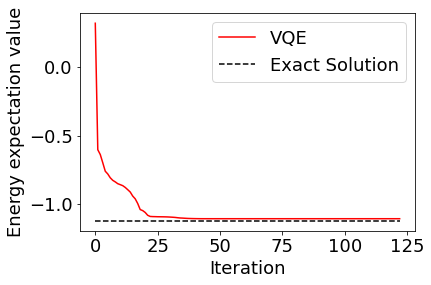

In [18]:

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [molecule.fci_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()
